In [1]:
import pandas as pd
import openpyxl
import tkinter.filedialog
import datetime
import msvcrt
from IPython.display import display
from tqdm import tqdm
from random import randint
import time

### Input new bills records and appended to the history

In [3]:
def strip_in_data(data):  # Remove leading and trailing spaces from column names and data.
    data = data.rename(columns={column_name: column_name.strip() for column_name in data.columns})
    data = data.applymap(lambda x: x.strip().strip('¥') if isinstance(x, str) else x)
    return data


def read_data_wx(path):  # 获取微信数据
    d_wx = pd.read_csv(path, header=16, skipfooter=0, encoding='utf-8')  # 数据获取，微信
    d_wx = d_wx.iloc[:, [0, 4, 7, 1, 2, 3, 5]]  # 按顺序提取所需列
    d_wx = strip_in_data(d_wx)  # 去除列名与数值中的空格。
    d_wx.iloc[:, 0] = d_wx.iloc[:, 0].astype('datetime64')  # 数据类型更改
    d_wx.iloc[:, 6] = d_wx.iloc[:, 6].astype('float64')  # 数据类型更改
    d_wx = d_wx.drop(d_wx[d_wx['收/支'] == '/'].index)  # 删除'收/支'为'/'的行
    d_wx.rename(columns={'当前状态': '支付状态', '交易类型': '类型', '金额(元)': '金额'}, inplace=True)  # 修改列名称
    d_wx.insert(1, '来源', "微信", allow_duplicates=True)  # 添加微信来源标识
    len1 = len(d_wx)
    print("Sucessfully Read " + str(len1) + " 「Wechat」bills\n")
    return d_wx


def read_data_zfb(path):  # 获取支付宝数据
    d_zfb = pd.read_csv(path, header=4, skipfooter=7, encoding='gbk')  # 数据获取，支付宝
    d_zfb = d_zfb.iloc[:, [2, 10, 11, 6, 7, 8, 9]]  # 按顺序提取所需列
    d_zfb = strip_in_data(d_zfb)  # 去除列名与数值中的空格。
    d_zfb.iloc[:, 0] = d_zfb.iloc[:, 0].astype('datetime64')  # 数据类型更改
    d_zfb.iloc[:, 6] = d_zfb.iloc[:, 6].astype('float64')  # 数据类型更改
    d_zfb = d_zfb.drop(d_zfb[d_zfb['收/支'] == ''].index)  # 删除'收/支'为空的行
    d_zfb.rename(columns={'交易创建时间': '交易时间', '交易状态': '支付状态', '商品名称': '商品', '金额（元）': '金额'}, inplace=True)  # 修改列名称
    d_zfb.insert(1, '来源', "支付宝", allow_duplicates=True)  # 添加支付宝来源标识
    len2 = len(d_zfb)
    print("Sucessfully Read " + str(len2) + " 「Alipay」bills\n")
    return d_zfb


def add_cols(data):  # 增加3列数据
    # 逻辑1：取值-1 or 1。-1表示支出，1表示收入。
    data.insert(8, '逻辑1', -1, allow_duplicates=True)  # 插入列，默认值为-1
    for index in range(len(data.iloc[:, 2])):  # 遍历第3列的值，判断为收入，则改'逻辑1'为1
        if data.iloc[index, 2] == '收入':
            data.iloc[index, 8] = 1

        # update 2021/12/29: 修复支付宝理财收支逻辑bug
        elif data.iloc[index, 5] == '蚂蚁财富-蚂蚁（杭州）基金销售有限公司' and '卖出' in data.iloc[index, 6]:
            data.iloc[index, 8] = 1
        elif data.iloc[index, 5] == '蚂蚁财富-蚂蚁（杭州）基金销售有限公司' and '转换至' in data.iloc[index, 6]:
            data.iloc[index, 8] = 0
        elif data.iloc[index, 2] == '其他' and '收益发放' in data.iloc[index, 6]:
            data.iloc[index, 8] = 1
        elif data.iloc[index, 2] == '其他' and '现金分红' in data.iloc[index, 6]:
            data.iloc[index, 8] = 1
        elif data.iloc[index, 2] == '其他' and '买入' in data.iloc[index, 6]:
            data.iloc[index, 8] = -1
        elif data.iloc[index, 2] == '其他':
            data.iloc[index, 8] = 0

    # 逻辑2：取值0 or 1。1表示计入，0表示不计入。
    data.insert(9, '逻辑2', 1, allow_duplicates=True)  # 插入列，默认值为1
    for index in range(len(data.iloc[:, 3])):  # 遍历第4列的值，判断为资金流动，则改'逻辑2'为0
        col3 = data.iloc[index, 3]
        if (col3 == '提现已到账') or (col3 == '已全额退款') or (col3 == '已退款') or (col3 == '退款成功') or (col3 == '还款成功') or (
                col3 == '交易关闭'):
            data.iloc[index, 9] = 0

    # 月份
    data.insert(1, '月份', 0, allow_duplicates=True)  # 插入列，默认值为0
    for index in range(len(data.iloc[:, 0])):
        time = data.iloc[index, 0]
        data.iloc[index, 1] = time.month  # 访问月份属性的值，赋给这月份列

    # 乘后金额
    data.insert(11, '乘后金额', 0, allow_duplicates=True)  # 插入列，默认值为0
    for index in range(len(data.iloc[:, 8])):
        money = data.iloc[index, 8] * data.iloc[index, 9] * data.iloc[index, 10]
        data.iloc[index, 11] = money
    return data

### Here is an example, and package this part into `DataHandler.py`

In [4]:
# New bills
filename = r'New_records_alipay.csv'
path = r'D:\Projects\Accounts\Dataloader'
data_zfb = read_data_zfb(path + '\\' + filename) # New bills
_new_part = add_cols(data_zfb)
_new_part.to_csv(path + '\\' + 'New_records_alipay.csv')

new_part = pd.read_csv(path + '\\' + 'New_records_alipay.csv', index_col=0).fillna('')


Sucessfully Read 148 「Alipay」bills



C:\Users\Administrator\AppData\Local\Temp\ipykernel_8328\3605182696.py:22: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  d_zfb = pd.read_csv(path, header=4, skipfooter=7, encoding='gbk')  # 数据获取，支付宝


In [6]:
# Historic bills
his_path = r'D:\Projects\Accounts\Dataloader\his\History_records_alipay.csv'
his_part = pd.read_csv(his_path, index_col=0).fillna('') # New bills

In [8]:
data_merge = pd.concat([his_part,new_part]).drop_duplicates()

In [9]:
data_merge.sort_values('交易时间')

,交易时间,月份,来源,收/支,支付状态,类型,交易对方,商品,金额,逻辑1,逻辑2,乘后金额
4204,2020-12-01 10:31:33,12,支付宝,不计收支,交易成功,即时到账交易,蚂蚁财富-蚂蚁（杭州）基金销售有限公司,蚂蚁财富-天弘中证银行指数A-买入,23.0,-1,1,-23.0
4203,2020-12-01 13:32:39,12,支付宝,不计收支,交易成功,支付宝担保交易,ellen0wang,基础综合英语 学生用书 研究生英语教材 pdf版电子书,5.5,-1,1,-5.5
4202,2020-12-01 13:37:35,12,支付宝,支出,交易成功,即时到账交易,App Store & Apple Music,App Store & Apple Music: 于 11.30完成的购买,3.0,-1,1,-3.0
4201,2020-12-01 21:53:47,12,支付宝,不计收支,交易成功,即时到账交易,麦当劳(深南西路分店餐厅),麦当劳餐厅(深圳) 有限公司,6.0,-1,1,-6.0
4200,2020-12-01 21:54:36,12,支付宝,不计收支,交易成功,即时到账交易,麦当劳(深南西路分店餐厅),麦当劳餐厅(深圳) 有限公司,0.1,-1,1,-0.1
...,...,...,...,...,...,...,...,...,...,...,...,...
4,2023-12-09 20:16:12,12,支付宝,支出,交易成功,即时到账交易,Valve,S2P1172140557 Steam Purchase,15.8,-1,1,-15.8
3,2023-12-10 13:13:45,12,支付宝,不计收支,交易成功,即时到账交易,上海都畅数字技术有限公司,三林东--西藏南路,4.0,-1,1,-4.0
2,2023-12-10 13:21:41,12,支付宝,不计收支,交易成功,即时到账交易,美团,大众点评订单-23121011100400000021574530283011,5.9,-1,1,-5.9
1,2023-12-10 14:17:04,12,支付宝,不计收支,交易成功,即时到账交易,上海都畅数字技术有限公司,马当路--商城路,3.0,-1,1,-3.0


In [10]:
data_merge.to_csv(r'D:\Projects\Accounts\Dataloader\his\History_records_alipay.csv')

### Analysis: Daily expense is the most available way to quantify behaviours. Here is the following steps:
1. Create a set that useful to collect your expense.
2. Categorize the expense by rows.
3. Do your individual analysis with some visualization.

#### My set (this part would be the key, it reflects your value system.
['必要性食品','非必要性食品','交通','一般耐用品','电子耐用品','订阅类信息服务或娱乐产品','线下娱乐或休闲','其他']

#### GPT-4.0 works.
- OpenAI's GPT4 API works in this situation.
- Time & Financial cost almost unavailable but still ok.

In [4]:
# read api key
with open(r'D:\accounts_key.txt','r') as key_file:
    OPENAI_API_KEY = key_file.readline()

import os
import openai 

openai.api_key = OPENAI_API_KEY

In [5]:
# read bills record
bill_df = pd.read_csv(r'D:\Projects\Accounts\Dataloader\his\History_records_alipay.csv', index_col=0)

In [11]:
# Bill
class Bill(object):
    def __init__(
        self,
        row:pd.core.series.Series,
        ):
        '''
        Categorization by row.
        '''
        self.row = row
        self.txt_eles = row.loc[['交易时间','交易对方','商品','金额']].values
        self.head_txts = '这是我的交易记录:' 
        self.txts = f'在{self.txt_eles[0]}, 我花费了{self.txt_eles[-1] }元人民币向{self.txt_eles[1]} 购买了{self.txt_eles[2]}。'
        self.tail_txts = \
        '''请帮我将这笔订单记录分类（只返回类别名称，如果难以判断则归类为“其他”），在以下类别 [食品,交通,耐用品,订阅类信息服务或娱乐产品,线下娱乐或休闲,理财] 中，上面这个订单属于哪一类?'''
        self.asking_texts = self.head_txts + self.txts + self.tail_txts
    
    # classifier
    def classify_expense(self):
        # try:
        response = openai.ChatCompletion.create(
            model='gpt-4-1106-preview',
            messages=[{"role": "system", "content": "你是一个根据订单记录对订单进行分类的智能助力，你言简意赅。你擅长结合交易对方的名称，交易发生的时间，交易金额判断支出类型。"},
                    {"role": "user", "content": self.asking_texts}],
            max_tokens=16
        )
        return response['choices'][0]['message']['content']


In [12]:
bill_df['时间'] =bill_df['交易时间'].copy() 
Bills_df = bill_df.set_index('时间').sort_index()
Bills_df
# Bills_df = bill_df.sort_values('交易时间')

,交易时间,月份,来源,收/支,支付状态,类型,交易对方,商品,金额,逻辑1,逻辑2,乘后金额
时间,,,,,,,,,,,,
2020-12-01 10:31:33,2020-12-01 10:31:33,12,支付宝,不计收支,交易成功,即时到账交易,蚂蚁财富-蚂蚁（杭州）基金销售有限公司,蚂蚁财富-天弘中证银行指数A-买入,23.0,-1,1,-23.0
2020-12-01 13:32:39,2020-12-01 13:32:39,12,支付宝,不计收支,交易成功,支付宝担保交易,ellen0wang,基础综合英语 学生用书 研究生英语教材 pdf版电子书,5.5,-1,1,-5.5
2020-12-01 13:37:35,2020-12-01 13:37:35,12,支付宝,支出,交易成功,即时到账交易,App Store & Apple Music,App Store & Apple Music: 于 11.30完成的购买,3.0,-1,1,-3.0
2020-12-01 21:53:47,2020-12-01 21:53:47,12,支付宝,不计收支,交易成功,即时到账交易,麦当劳(深南西路分店餐厅),麦当劳餐厅(深圳) 有限公司,6.0,-1,1,-6.0
2020-12-01 21:54:36,2020-12-01 21:54:36,12,支付宝,不计收支,交易成功,即时到账交易,麦当劳(深南西路分店餐厅),麦当劳餐厅(深圳) 有限公司,0.1,-1,1,-0.1
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-09 20:16:12,2023-12-09 20:16:12,12,支付宝,支出,交易成功,即时到账交易,Valve,S2P1172140557 Steam Purchase,15.8,-1,1,-15.8
2023-12-10 13:13:45,2023-12-10 13:13:45,12,支付宝,不计收支,交易成功,即时到账交易,上海都畅数字技术有限公司,三林东--西藏南路,4.0,-1,1,-4.0
2023-12-10 13:21:41,2023-12-10 13:21:41,12,支付宝,不计收支,交易成功,即时到账交易,美团,大众点评订单-23121011100400000021574530283011,5.9,-1,1,-5.9


In [15]:
# cates = {}

In [20]:
for idx, rcd in tqdm(Bills_df.iterrows()):
    if idx in cates.keys():
        continue
    
    one_bill = Bill(rcd)
    cates[idx] = one_bill.classify_expense()
    print(rcd['商品'],cates[idx])
    time.sleep(randint(1,2))


0it [00:00, ?it/s]

App Store & Apple Music: 于 11.30完成的购买 订阅类信息服务或娱乐产品


3it [00:04,  1.47s/it]

麦当劳餐厅(深圳) 有限公司 食品


4it [00:09,  2.56s/it]

麦当劳餐厅(深圳) 有限公司 食品


5it [00:11,  2.34s/it]

麦当劳餐厅(深圳) 有限公司 食品


6it [00:14,  2.57s/it]

【bilibili】现货 万代 鬼灭之刃 炭治郎&amp;祢豆子 Q版手办摆件 耐用品


7it [00:17,  2.69s/it]

艾漫正版 排球少年周边人物立绘亚克力立牌摆件【现货】 订阅类信息服务或娱乐产品


8it [00:20,  2.92s/it]

宠物小精灵星之卡比动漫手办神奇宝贝袋装手办车载摆件蛋糕场景版 耐用品


9it [00:23,  2.78s/it]

蚂蚁财富-天弘中证银行指数A-买入 理财


10it [00:25,  2.54s/it]

思迅Pay-微信-A超市 食品


11it [00:29,  2.99s/it]

海贼王手办zero索隆艾斯卡塔库栗路飞公仔摆件周边礼物全套限量版 耐用品


12it [00:31,  2.80s/it]

思迅Pay-微信-A超市 食品


13it [00:34,  2.83s/it]

麦当劳餐厅(深圳) 有限公司 食品


14it [00:37,  2.86s/it]

商品 食品


15it [00:39,  2.63s/it]

韶音AfterShokz AS800骨传导运动蓝牙耳机骨传感跑步无线Aeropex 耐用品


16it [00:41,  2.44s/it]

主动还款-花呗2020年12月账单 理财


17it [00:44,  2.74s/it]

蚂蚁财富-天弘中证银行指数A-买入 理财


18it [00:48,  2.95s/it]

退款-宠物小精灵星之卡比动漫手办神奇宝贝袋装手办车载摆件蛋糕场景版 耐用品


19it [00:51,  3.02s/it]

商品 食品


20it [00:55,  3.23s/it]

商品 食品


21it [00:58,  3.32s/it]

益田福伴生活超市收银员:606-7038 食品


22it [01:00,  2.93s/it]

蚂蚁财富-天弘中证银行指数A-买入 理财


23it [01:02,  2.64s/it]

蚂蚁财富-天弘中证银行指数A-买入 理财


24it [01:06,  3.00s/it]

条码支付-A 食品


25it [01:10,  3.39s/it]

深圳市南山区荣润家龙百货商行-支付宝 食品


26it [01:13,  3.04s/it]

麦当劳餐厅(深圳) 有限公司 食品


27it [01:14,  2.67s/it]

深圳全家购物 食品


28it [01:17,  2.61s/it]

转账 其他


29it [01:19,  2.47s/it]

转账收款到余额宝 理财


30it [01:23,  3.02s/it]

蚂蚁财富-天弘中证银行指数A-买入 理财


31it [01:25,  2.73s/it]

益田假日广场B2 线下娱乐或休闲


32it [01:29,  3.08s/it]

益田福伴生活超市收银员:606-7039 食品


33it [01:32,  3.04s/it]

GOODS 食品


34it [01:36,  3.31s/it]

蚂蚁财富-天弘中证银行指数A-买入 理财


35it [01:39,  3.25s/it]

App Store & Apple Music: 于 12.07完成的购买 订阅类信息服务或娱乐产品


36it [01:43,  3.33s/it]

益田福伴生活超市收银员:606-7038 食品


37it [01:45,  3.09s/it]

商品 食品


38it [01:47,  2.76s/it]

蚂蚁财富-天弘中证银行指数A-买入 理财


39it [01:49,  2.53s/it]

条码支付-A 食品


40it [01:51,  2.35s/it]

麦当劳餐厅(深圳) 有限公司 食品


41it [01:53,  2.25s/it]

深圳全家购物 食品


42it [01:55,  2.15s/it]

App Store & Apple Music: 于 12.09完成的购买 订阅类信息服务或娱乐产品


43it [01:59,  2.71s/it]

蚂蚁财富-天弘中证银行指数A-买入 理财


44it [02:01,  2.44s/it]

思迅Pay-微信-A超市 食品


45it [02:04,  2.58s/it]

商品 食品


46it [02:07,  2.71s/it]

【预售】原创款 动物系列开衫 JK制服 学生针织毛衣 加厚 耐用品


47it [02:09,  2.61s/it]

【现货】原创款 日本学生制服小方领角襟刺绣长袖衬衫校服衬衫 等多件 耐用品


48it [02:12,  2.76s/it]

桂格原味即食麦片1000g*3 食品


50it [02:15,  2.17s/it]

金味麦片原味营养麦片懒人代餐速溶燕麦片学生早餐即食冲饮600g 等多件 食品


51it [02:19,  2.47s/it]

蚂蚁财富-天弘中证银行指数A-买入 理财


52it [02:22,  2.71s/it]

深圳全家购物 食品


53it [02:24,  2.54s/it]

美团收银766644605549862912 食品


54it [02:27,  2.59s/it]

深圳全家购物 食品


55it [02:30,  2.83s/it]

蚂蚁财富-天弘中证银行指数A-买入 理财


56it [02:32,  2.61s/it]

麦当劳餐厅(深圳) 有限公司 食品


57it [02:35,  2.71s/it]

转账 理财


58it [02:39,  2.91s/it]

广东省天天果品汇 食品


59it [02:41,  2.70s/it]

条码支付 食品


60it [02:43,  2.50s/it]

App Store & Apple Music: 于 12.12完成的购买 订阅类信息服务或娱乐产品


61it [02:45,  2.46s/it]

蚂蚁财富-天弘中证银行ETF联接A-买入 理财


62it [02:47,  2.31s/it]

蚂蚁财富-天弘中证银行ETF联接A-买入 理财


63it [02:50,  2.48s/it]

点点肠粉：8元 食品


64it [02:53,  2.72s/it]

条码支付-B 食品


65it [02:55,  2.46s/it]

蚂蚁财富-天弘中证银行ETF联接A-买入 理财


66it [02:58,  2.61s/it]

商品 食品


67it [03:01,  2.72s/it]

蚂蚁财富-天弘中证银行ETF联接A-买入 理财


68it [03:05,  2.95s/it]

条码支付-A 食品


69it [03:07,  2.82s/it]

App Store & Apple Music: 于 12.16完成的购买 订阅类信息服务或娱乐产品


70it [03:10,  2.81s/it]

支付宝APP支付 线下娱乐或休闲


71it [03:14,  3.17s/it]

蚂蚁财富-天弘中证银行ETF联接A-买入 理财


72it [03:17,  3.26s/it]

雀巢香滑咖啡210ml 食品


73it [03:20,  2.89s/it]

椒气小姐：22.82元 食品


74it [03:22,  2.72s/it]

益田福伴生活超市收银员:606-7038 食品


75it [03:26,  3.04s/it]

主动还款-花呗2020年12月账单 理财


76it [03:28,  2.96s/it]

蚂蚁财富-天弘中证银行ETF联接A-买入 理财


77it [03:32,  3.01s/it]

充值-普通充值 订阅类信息服务或娱乐产品


78it [03:35,  3.18s/it]

提现-快速提现 理财


79it [03:38,  3.21s/it]

商品 食品


80it [03:40,  2.83s/it]

深圳市南山区果满园便利店-支付宝 食品


81it [03:43,  2.87s/it]

充值-普通充值 订阅类信息服务或娱乐产品


82it [03:47,  2.99s/it]

提现-快速提现 理财


83it [03:49,  2.78s/it]

餐台2结账1000016251 食品


84it [03:54,  3.41s/it]

手机充值 订阅类信息服务或娱乐产品


85it [03:57,  3.40s/it]

商品 订阅类信息服务或娱乐产品


86it [04:01,  3.52s/it]

美团订单-20122011100400000001655034003011 食品


87it [04:04,  3.42s/it]

商品 食品


88it [04:07,  3.27s/it]

深圳全家购物 食品


89it [04:10,  3.12s/it]

App Store & Apple Music: 于 12.21完成的购买 订阅类信息服务或娱乐产品


90it [04:12,  2.88s/it]

蚂蚁财富-天弘中证银行ETF联接A-买入 理财


91it [04:16,  3.28s/it]

App Store & Apple Music: 于 12.21完成的购买 订阅类信息服务或娱乐产品


92it [04:19,  3.16s/it]

yitian 线下娱乐或休闲


93it [04:22,  3.10s/it]

手机充值 订阅类信息服务或娱乐产品


94it [04:27,  3.64s/it]

蚂蚁财富-天弘中证银行ETF联接A-买入 理财


95it [04:29,  3.13s/it]

益田福伴生活超市收银员:606-7039 食品


96it [04:32,  3.09s/it]

退款-支付宝APP支付 其他


97it [04:34,  2.76s/it]

【预售】原创款 动物系列开衫 JK制服 学生针织毛衣 加厚 耐用品


98it [04:38,  3.07s/it]

蚂蚁财富-天弘中证银行ETF联接A-买入 理财


99it [04:40,  2.72s/it]

深圳书店(付码) 订阅类信息服务或娱乐产品


100it [04:42,  2.70s/it]

蚂蚁财富-天弘中证银行ETF联接A-买入 理财


101it [04:46,  3.03s/it]

雀巢香滑咖啡210ml 食品


102it [04:48,  2.76s/it]

商品 食品


103it [04:50,  2.46s/it]

江西有家实业有限公司-消费 食品


104it [04:53,  2.67s/it]

蚂蚁财富-天弘中证银行ETF联接A-买入 理财


105it [04:55,  2.54s/it]

金百味麻岭店 食品


106it [04:58,  2.66s/it]

麦当劳餐厅(深圳) 有限公司 食品


107it [05:01,  2.71s/it]

网易云音乐-会员自动续费 订阅类信息服务或娱乐产品


108it [05:04,  2.86s/it]

深圳全家购物 食品


109it [05:07,  2.67s/it]

商品 耐用品


110it [05:09,  2.54s/it]

美团订单-20122711100400000002175091928011 食品


111it [05:12,  2.60s/it]

江西有家实业有限公司-消费 食品


112it [05:15,  2.73s/it]

蚂蚁财富-天弘中证银行ETF联接A-买入 理财


113it [05:16,  2.45s/it]

臻品鲜粿CoCopark店 食品


114it [05:19,  2.44s/it]

阿杏饭团-消费 食品


115it [05:22,  2.60s/it]

江西有家实业有限公司-消费 食品


116it [05:24,  2.39s/it]

街电充电宝 耐用品


117it [05:28,  2.93s/it]

江西有家实业有限公司-消费 食品


118it [05:31,  2.99s/it]

江西有家实业有限公司-消费 食品


119it [05:34,  3.10s/it]

支付码:332745 美颐美·侨城西店(6911654066498156362) 食品


120it [05:37,  3.08s/it]

商品 食品


121it [05:39,  2.73s/it]

美团订单-20123011100400000002361577360011 食品


122it [05:44,  3.21s/it]

支付码:321420 美颐美·侨城西店(6912006232601532234) 食品


123it [05:46,  2.93s/it]

商品 食品


124it [05:49,  2.91s/it]

蚂蚁财富-天弘中证银行ETF联接A-买入 理财


125it [05:51,  2.72s/it]

【实体礼品卡】基本操作 一个人工智能的诞生 可操作的交互视频课 订阅类信息服务或娱乐产品


126it [05:54,  2.91s/it]

App Store & Apple Music: 于 01.01完成的购买 订阅类信息服务或娱乐产品


127it [05:57,  2.73s/it]

商品 订阅类信息服务或娱乐产品


128it [05:59,  2.61s/it]

收钱码收款 订阅类信息服务或娱乐产品


129it [06:04,  3.23s/it]

FuRyu?VOCALOID 初音未来 兔女郎Ver. Anmi原画 景品手办 附独家特典 订阅类信息服务或娱乐产品


130it [06:08,  3.63s/it]

条码支付-B 食品


131it [06:11,  3.35s/it]

收钱码收款 订阅类信息服务或娱乐产品


132it [06:14,  3.21s/it]

发普通红包 线下娱乐或休闲


133it [06:18,  3.49s/it]

阳光出行 交通


134it [06:21,  3.43s/it]

条码支付-天虹 食品


135it [06:24,  3.33s/it]

益田福伴生活超市收银员:606-7038 食品


136it [06:27,  3.04s/it]

充值-普通充值 订阅类信息服务或娱乐产品


137it [06:29,  2.83s/it]

余额宝-自动转入 理财


138it [06:33,  3.14s/it]

余额宝-转出到余额 理财


139it [06:36,  3.16s/it]

提现-快速提现 理财


140it [06:39,  3.15s/it]

充值-普通充值 订阅类信息服务或娱乐产品


141it [06:43,  3.32s/it]

提现-快速提现 理财


142it [06:45,  2.90s/it]

蚂蚁财富-天弘中证银行ETF联接A-买入 理财


143it [06:47,  2.69s/it]

McDonaldsChina 食品


144it [06:52,  3.20s/it]

蚂蚁财富-天弘中证银行ETF联接A-买入 理财


145it [06:55,  3.19s/it]

订单付款 食品


146it [06:57,  2.77s/it]

益田福伴生活超市收银员:606-7038 食品


147it [07:00,  3.09s/it]

思迅Pay-微信-A超市 食品


148it [07:03,  2.82s/it]

蚂蚁财富-天弘中证银行ETF联接A-买入 理财


149it [07:06,  3.06s/it]

印萌自助打印：网上门店 订阅类信息服务或娱乐产品


150it [07:13,  4.10s/it]

蚂蚁财富-天弘中证银行ETF联接A-买入 理财


151it [07:16,  3.82s/it]

订单付款 食品


152it [07:18,  3.34s/it]

App Store & Apple Music: 于 01.07完成的购买 订阅类信息服务或娱乐产品


153it [07:21,  3.25s/it]

蚂蚁财富-天弘中证银行ETF联接A-买入 理财


154it [07:24,  3.00s/it]

App Store & Apple Music: 于 01.09完成的购买 订阅类信息服务或娱乐产品


155it [07:28,  3.37s/it]

美团收银777476439053545472 食品


156it [07:30,  2.89s/it]

街电充电宝 耐用品


157it [07:32,  2.88s/it]

益田福伴生活超市收银员:606-7038 食品


158it [07:35,  2.84s/it]

百度文库VIP-1天 订阅类信息服务或娱乐产品


159it [07:38,  2.82s/it]

U净洗衣 订阅类信息服务或娱乐产品


160it [07:42,  3.19s/it]

订单付款 食品


161it [07:44,  2.81s/it]

蚂蚁财富-天弘中证银行ETF联接A-买入 理财


162it [07:47,  2.81s/it]

余额宝-单次转入 理财


163it [07:50,  2.99s/it]

余额宝-单次转入 理财


164it [07:53,  2.98s/it]

蚂蚁财富-天弘中证银行ETF联接A-买入 理财


165it [07:56,  2.94s/it]

订单付款 食品


166it [07:58,  2.61s/it]

支付码:331932 美颐美·侨城西店(6916847141537212234) 食品


167it [08:02,  3.11s/it]

【官方旗舰店】雅伊利吉他D950/D1500单板民谣木吉他雅依利D1300 耐用品


168it [08:05,  3.20s/it]

【官方旗舰店】雅伊利吉他D950/D1500单板民谣木吉他雅依利D1300 耐用品


169it [08:08,  2.86s/it]

【官方旗舰店】雅伊利吉他D950/D1500单板民谣木吉他雅依利D1300 耐用品


170it [08:10,  2.80s/it]

App Store & Apple Music: 于 01.12完成的购买 订阅类信息服务或娱乐产品


171it [08:13,  2.77s/it]

蚂蚁财富-天弘中证银行ETF联接A-买入 理财


172it [08:15,  2.48s/it]

美团订单-21011311100400000003426379420011 食品


173it [08:17,  2.43s/it]

补差价专用链接 耐用品


174it [08:19,  2.38s/it]

歌志轩-深圳南山益田假日广场店-扫码付-YYSZ02001-210113-02232030 食品


175it [08:21,  2.20s/it]

条码支付-A 食品


176it [08:23,  2.07s/it]

蚂蚁财富-天弘中证银行ETF联接A-买入 理财


177it [08:26,  2.37s/it]

旺客基黄焖鸡-深大店 食品


178it [08:29,  2.54s/it]

商品 食品


179it [08:31,  2.33s/it]

益田福伴生活超市收银员:606-7038 食品


180it [08:34,  2.59s/it]

商品 耐用品


181it [08:36,  2.57s/it]

蚂蚁财富-天弘中证银行ETF联接A-买入 理财


182it [08:40,  2.85s/it]

商品 食品


183it [08:43,  2.93s/it]

商品 订阅类信息服务或娱乐产品


184it [08:45,  2.74s/it]

商品 食品


185it [08:47,  2.48s/it]

益田福伴生活超市收银员:606-7041 食品


186it [08:49,  2.27s/it]

发普通红包 其他


187it [08:52,  2.39s/it]

益田福伴生活超市收银员:606-7038 食品


188it [08:55,  2.68s/it]

深圳全家购物 食品


189it [08:57,  2.42s/it]

深圳南山海雅店 食品


190it [08:59,  2.28s/it]

吾非书店 订阅类信息服务或娱乐产品


191it [09:02,  2.69s/it]

美团充电宝 耐用品


192it [09:05,  2.56s/it]

订单结束 订阅类信息服务或娱乐产品


193it [09:09,  3.11s/it]

美团充电宝 耐用品


194it [09:12,  3.16s/it]

美团充电宝 耐用品


195it [09:17,  3.55s/it]

自动解冻-美团充电宝 耐用品


196it [09:19,  3.07s/it]

退款-发普通红包 其他


197it [09:21,  2.97s/it]

甲咚海南鸡饭【讯美店】-消费 食品


198it [09:25,  3.01s/it]

条码支付-A 食品


199it [09:26,  2.66s/it]

蚂蚁财富-天弘中证银行ETF联接A-买入 理财


200it [09:29,  2.49s/it]

思迅Pay-微信-A超市 食品


201it [09:32,  2.72s/it]

益田福伴生活超市收银员:606-7038 食品


202it [09:35,  2.91s/it]

主动还款-花呗2021年01月账单 理财


203it [09:39,  3.29s/it]

主动还款-花呗2021年01月账单 理财


204it [09:42,  3.19s/it]

711Payment 食品


205it [09:44,  2.83s/it]

转账 理财


206it [09:47,  2.84s/it]

条码支付-A 食品


207it [09:50,  2.93s/it]

蚂蚁财富-天弘中证银行ETF联接A-买入 理财


208it [09:52,  2.63s/it]

深圳全家购物 食品


209it [09:54,  2.46s/it]

麦当劳餐厅(深圳) 有限公司 食品


210it [09:56,  2.36s/it]

条码支付-A 食品


211it [09:59,  2.57s/it]

手机充值 订阅类信息服务或娱乐产品


212it [10:02,  2.69s/it]

备用金取出至余额 理财


213it [10:05,  2.76s/it]

主动还款-花呗2021年01月账单 理财


214it [10:08,  2.77s/it]

提现-快速提现 理财


215it [10:10,  2.54s/it]

蚂蚁财富-天弘中证银行ETF联接A-买入 理财


216it [10:13,  2.67s/it]

商品 食品


In [ ]:
cates

{'2020-12-01 10:31:33': '理财', '2020-12-01 13:32:39': '订阅类信息服务或娱乐产品'}

In [ ]:
Bills_df['cate'] = pd.Series(cates)

In [ ]:
Bills_df

,交易时间,月份,来源,收/支,支付状态,类型,交易对方,商品,金额,逻辑1,逻辑2,乘后金额,cate
时间,,,,,,,,,,,,,
2020-12-01 10:31:33,2020-12-01 10:31:33,12,支付宝,不计收支,交易成功,即时到账交易,蚂蚁财富-蚂蚁（杭州）基金销售有限公司,蚂蚁财富-天弘中证银行指数A-买入,23.0,-1,1,-23.0,理财
2020-12-01 13:32:39,2020-12-01 13:32:39,12,支付宝,不计收支,交易成功,支付宝担保交易,ellen0wang,基础综合英语 学生用书 研究生英语教材 pdf版电子书,5.5,-1,1,-5.5,订阅类信息服务或娱乐产品
2020-12-01 13:37:35,2020-12-01 13:37:35,12,支付宝,支出,交易成功,即时到账交易,App Store & Apple Music,App Store & Apple Music: 于 11.30完成的购买,3.0,-1,1,-3.0,订阅类信息服务或娱乐产品
2020-12-01 21:53:47,2020-12-01 21:53:47,12,支付宝,不计收支,交易成功,即时到账交易,麦当劳(深南西路分店餐厅),麦当劳餐厅(深圳) 有限公司,6.0,-1,1,-6.0,'非必要性食品'
2020-12-01 21:54:36,2020-12-01 21:54:36,12,支付宝,不计收支,交易成功,即时到账交易,麦当劳(深南西路分店餐厅),麦当劳餐厅(深圳) 有限公司,0.1,-1,1,-0.1,非必要性食品
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-09 20:16:12,2023-12-09 20:16:12,12,支付宝,支出,交易成功,即时到账交易,Valve,S2P1172140557 Steam Purchase,15.8,-1,1,-15.8,NaN
2023-12-10 13:13:45,2023-12-10 13:13:45,12,支付宝,不计收支,交易成功,即时到账交易,上海都畅数字技术有限公司,三林东--西藏南路,4.0,-1,1,-4.0,NaN
2023-12-10 13:21:41,2023-12-10 13:21:41,12,支付宝,不计收支,交易成功,即时到账交易,美团,大众点评订单-23121011100400000021574530283011,5.9,-1,1,-5.9,NaN


In [ ]:
Bills_df.to_excel('CateFinishedBill.xlsx')

#### For free version, we try using LLAMA-2-70B.
- Bad classifying perform.
- Same problem with GPT-3.5-turbo, usually return too much more than I ask for.
- Sometimes successfully limit the returns.

In [37]:
import os
import replicate

In [88]:
output = replicate.run(
  "meta/llama-2-70b-chat:02e509c789964a7ea8736978a43525956ef40397be9033abf9fd2badfe68c9e3",
  input={
    "debug": False,
    "top_k": 50,
    "top_p": 1,
    "prompt": "“12:41:20在上海都畅数字技术有限公司购买了三林东--西藏南路”。 For this expense record text, what would you categorize it to? 'food','sanck','transportation','durable goods','electronic'or'subscription-based service' or 'offline entertainment'? Don't say any unnecessary, you must give me ONE WORD of those categories.",
    "temperature": 1,
    "system_prompt": "You are a good assistant good at categorizing expense base on chinese texts.",
    "max_new_tokens": 16,
    "min_new_tokens": 2
  })

In [89]:
for item in output:
    print(item, end="")

 " Durable goods"

#### Some Analysis

In [24]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

In [4]:
cated_bill = pd.read_excel('CateFinishedBill.xlsx')

<AxesSubplot:ylabel='金额'>

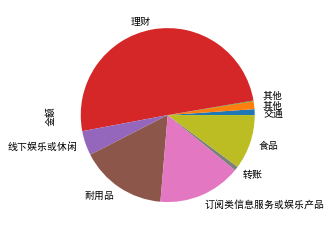

In [25]:
cated_bill2021 = cated_bill[(cated_bill['交易时间']>='2021-01-01')&(cated_bill['交易时间']<'2022-01-01')]
cated_bill2021.groupby('cate')['金额'].sum()
cated_bill2021.groupby('cate')['金额'].sum().plot(kind='pie')

- In 2021, most of outflows to Finance, I thought it might be includes most of my transfers, which should not considered as a 'Expense'. Let's make a confirm. 

In [34]:
cated_bill2021[cated_bill2021.cate=='理财'].groupby('商品')['金额'].sum()

商品
主动还款-花呗2021年01月账单            453.37
主动还款-花呗2021年02月账单            521.62
主动还款-花呗2021年03月账单            250.78
主动还款-花呗2021年04月账单            298.23
主动还款-花呗2021年05月账单            304.62
                             ...   
蚂蚁财富-天弘中证银行ETF联接A-卖出至余额宝    6236.58
账户结息-2021.09.21                0.01
账户结息-2021.12.21                0.04
转账                          1713.00
转账收款到余额宝                    3513.00
Name: 金额, Length: 159, dtype: float64

- It's clear that most of transfer between families and cash flows like credit card payment was included.